# Fine-tuning ResNet18 with CCT20

### Imports and CUDA check

In [165]:
import os
import random
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [166]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU for PyTorch.")
else:
    print("CUDA is not available. Using CPU for PyTorch.")

CUDA is available. You can use GPU for PyTorch.


In [167]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset Preparation

In [229]:
class CCTDataset(Dataset):
    def __init__(self, json_file, images_dir, transform=None, label_mapping=None):
        with open(json_file, 'r') as f:
            data = json.load(f)

        self.images = {img["id"]: img["file_name"] for img in data["images"]}
        self.annotations = data.get("annotations", [])
        self.images_dir = images_dir
        self.transform = transform
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_id = ann["image_id"]
        img_path = os.path.join(self.images_dir, self.images[img_id])
        image = Image.open(img_path).convert('RGB')
        
        # Crop the image using bounding box coordinates from json files
        bbox = ann.get("bbox")
        if bbox:
            x, y, w, h = bbox
            image = image.crop((x, y, x + w, y + h))
        
        if self.transform:
            image = self.transform(image)
        label = self.label_mapping[ann["category_id"]]
        return image, label

In [205]:
def get_label_mapping(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    categories = data["categories"]
    mapping = {category["id"]: idx for idx, category in enumerate(categories)}
    return mapping

In [230]:
train_json = 'cct20-metadata/train_annotations.json'
cis_val_json = 'cct20-metadata/cis_val_annotations.json'
trans_val_json = 'cct20-metadata/trans_val_annotations.json'
cis_test_json = 'cct20-metadata/cis_test_annotations.json'
trans_test_json = 'cct20-metadata/trans_test_annotations.json'
images_dir = 'cct20-images'

# Create label mapping and determine number of classes
label_mapping = get_label_mapping(train_json)
num_classes = len(label_mapping)

### Dataset Augmentation

In [231]:
train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    # transforms.RandomRotation(20),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = val_transform

In [232]:
train_dataset = CCTDataset(train_json, images_dir, transform=train_transform, label_mapping=label_mapping)

cis_val_dataset = CCTDataset(cis_val_json, images_dir, transform=val_transform, label_mapping=label_mapping)
trans_val_dataset = CCTDataset(trans_val_json, images_dir, transform=val_transform, label_mapping=label_mapping)
val_dataset = ConcatDataset([cis_val_dataset, trans_val_dataset])

cis_test_dataset = CCTDataset(cis_test_json, images_dir, transform=test_transform, label_mapping=label_mapping)
trans_test_dataset = CCTDataset(trans_test_json, images_dir, transform=test_transform, label_mapping=label_mapping)
test_dataset = ConcatDataset([cis_test_dataset, trans_test_dataset])

In [233]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### BBox Cropping Verification

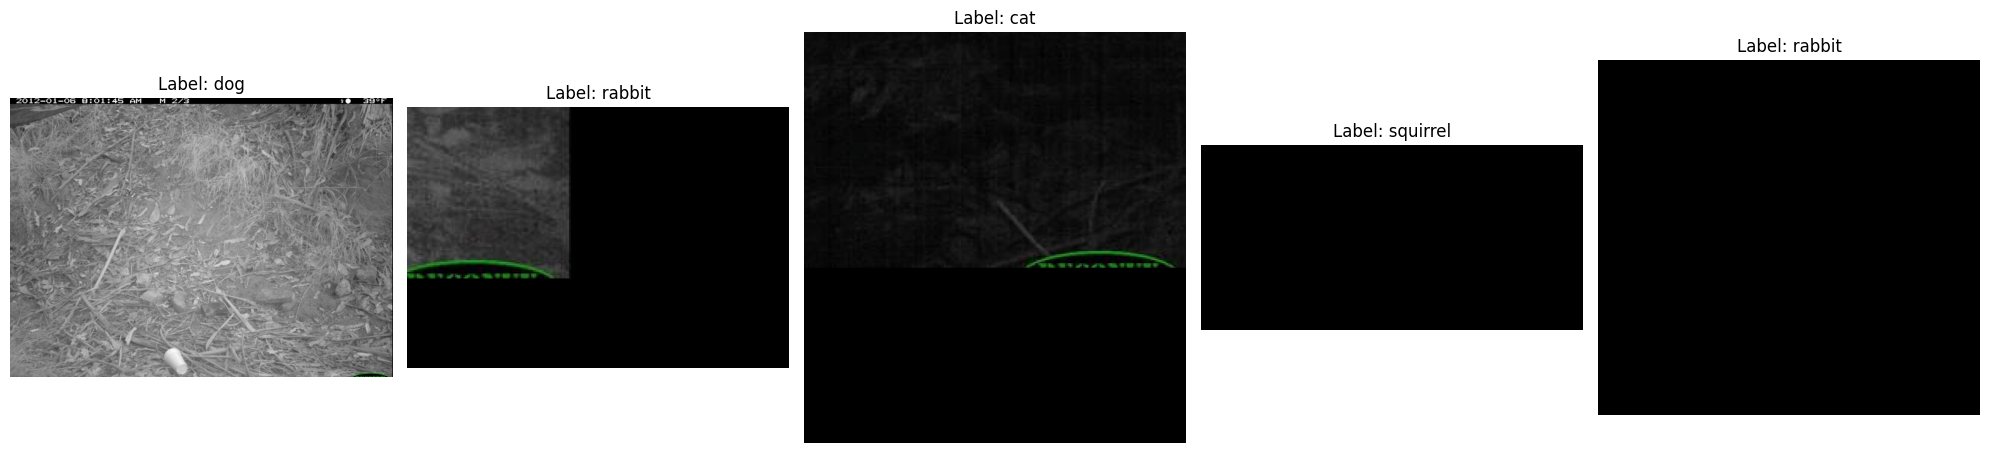

In [264]:
# Getting the class names
with open(train_json, 'r') as f:
    data = json.load(f)
idx_to_name = {label_mapping[cat['id']]: cat['name'] for cat in data['categories']}

# Plot 5 random images from the training dataset to verify the crop
indices = random.sample(range(len(train_dataset)), 5)
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for ax, idx in zip(axs, indices):
    img, label = train_dataset[idx]
    
    # Convert tensor image to numpy array and unnormalize
    img = img.cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f'Label: {idx_to_name[label]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Model Import

In [10]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

c:\Users\diogo\Documents\Repos\cifar10-image-classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\diogo\Documents\Repos\cifar10-image-classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

### Training Loop

In [12]:
num_epochs = 100
best_f1 = 0.0
epochs_no_improve = 0
patience = 20
train_losses = []
val_losses = []
f1_scores = []

best_model_wts = copy.deepcopy(model.state_dict())  # Saves weight of epoch with best f1-score

In [ ]:
for epoch in range(1, num_epochs + 1):
    if epoch == 2:
        print(f'Completed the 1st epoch. Something is actually happening!\n')
    
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)

    scheduler.step()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    f1_scores.append(epoch_f1)


    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}, Val F1-score: {epoch_f1:.4f}')

    if epochs_no_improve >= patience:
        print(f'Early stopping triggered at epoch {epoch}/{num_epochs}: no improvement in {patience} epochs.')
        break

In [ ]:
model.load_state_dict(best_model_wts)  # Loads weight of best epoch

In [ ]:
trained_models_dir = 'trained-models'
model_name = 'cct20_resnet.pth'

os.makedirs(trained_models_dir, exist_ok=True)  # Create folder if it doesn't exist

torch.save(model.state_dict(), os.path.join(trained_models_dir, model_name))

print(f"Model saved to '{os.path.join(trained_models_dir, model_name)}'.")

### Training Performance

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Evolution')
plt.legend()
plt.show()

### Testing

In [ ]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(classification_report(all_test_labels, all_test_preds, target_names=list(label_mapping.keys())))